You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# Classification

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=61e08a2a1c34accaf63b95c633047563b8f81fd9a16148cd213d03319b34cc3d
  Stored in directory: /root/.cache/pip/wheels/26/56/da/ea90b6b66dc5e72379a64e2819815066873f00c1350126e876
Successfully built empiricaldist


In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [3]:
from utils import set_pyplot_params

set_pyplot_params()

In [4]:
from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

In [5]:
import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle +
                                   marker_cycle +
                                   line_cycle)

Classification might be the most well-known application of Bayesian methods, made famous in the 1990s as the basis of the first generation of [spam filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering).

In this chapter, I'll demonstrate Bayesian classification using data collected and made available by Dr. Kristen Gorman at the Palmer Long-Term Ecological Research Station in Antarctica (see Gorman, Williams, and Fraser, ["Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus *Pygoscelis*)"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), March 2014).
We'll use this data to classify penguins by species.

The following cell downloads the raw data.

In [6]:
# Load the data files from
# https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

download('https://github.com/allisonhorst/palmerpenguins/raw/main/inst/extdata/penguins_raw.csv')

Downloaded penguins_raw.csv


## Penguin Data

I'll use Pandas to load the data into a `DataFrame`.

In [7]:
import pandas as pd

df = pd.read_csv('penguins_raw.csv').dropna(subset=['Body Mass (g)'])
df.shape

(342, 17)

The dataset contains one row for each penguin and one column for each variable.

In [8]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,2007-11-16,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN


For convenience, I'll create a new column called `Species2` that contains a shorter version of the species names.

In [9]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

Three species of penguins are represented in the dataset:  Adélie, Chinstrap and Gentoo.

These species are shown in this illustration (by Allison Horst, available under the [CC-BY](https://creativecommons.org/licenses/by/2.0/) license):

<img width="400" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAWkZ0U4AA1CQf.jpeg" alt="Drawing of three penguin species">

The measurements we'll use are:

* Body Mass in grams (g).

* Flipper Length in millimeters (mm).

* Culmen Length in millimeters.  

* Culmen Depth in millimeters.

If you are not familiar with the word "culmen", it refers to the [top margin of the beak](https://en.wikipedia.org/wiki/Bird_measurement#Culmen).

The culmen is shown in the following illustration (also by Allison Horst):

<img width="300" src="https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/images/EaAXQn8U4AAoKUj.jpeg">

These measurements will be most useful for classification if there are substantial differences between species and small variation within species.  To see whether that is true, and to what degree, I'll plot cumulative distribution functions (CDFs) of each measurement for each species.

The following function takes the `DataFrame` and a column name.
It returns a dictionary that maps from each species name to a `Cdf` of the values in the column named `colname`.

In [10]:
def make_cdf_map(df, colname, by='Species2'):
    """Make a CDF for each species."""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

The following function plots a `Cdf` of the values in the given column for each species:

In [11]:
from empiricaldist import Cdf
from utils import decorate

def plot_cdfs(df, colname, by='Species2'):
    """Make a CDF for each species.

    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname, by)

    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')

    decorate(xlabel=colname,
             ylabel='CDF')

Here's what the distributions look like for culmen length.

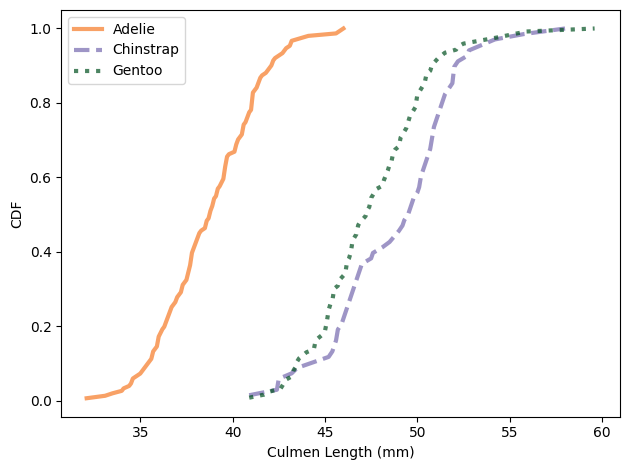

In [12]:
colname = 'Culmen Length (mm)'
plot_cdfs(df, colname)

It looks like we can use culmen length to identify  Adélie penguins, but the distributions for the other two species almost entirely overlap.

Here are the distributions for flipper length.

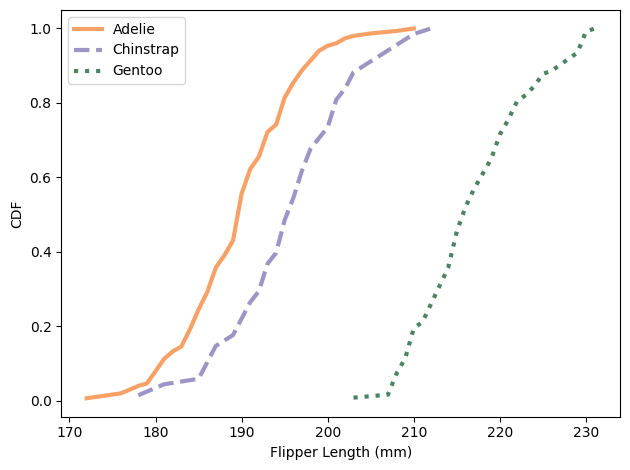

In [13]:
colname = 'Flipper Length (mm)'
plot_cdfs(df, colname)

Using flipper length, we can distinguish Gentoo penguins from the other two species.  So with just these two features, it seems like we should be able to classify penguins with some accuracy.

All of these CDFs show the sigmoid shape characteristic of the normal distribution;  I will take advantage of that observation in the next section.

Here are the distributions for culmen depth.

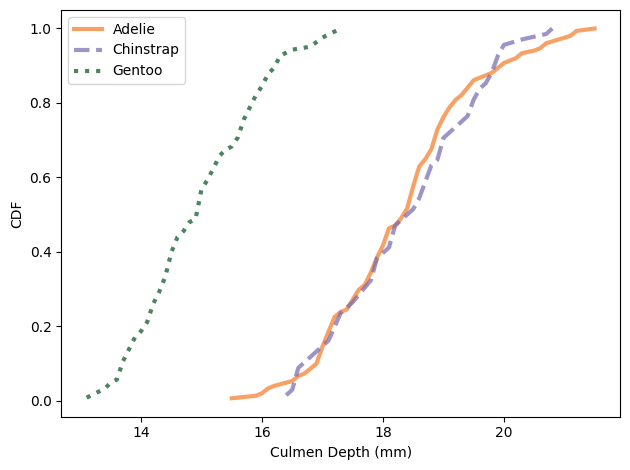

In [14]:
colname = 'Culmen Depth (mm)'
plot_cdfs(df, colname)

And here are the distributions of body mass.

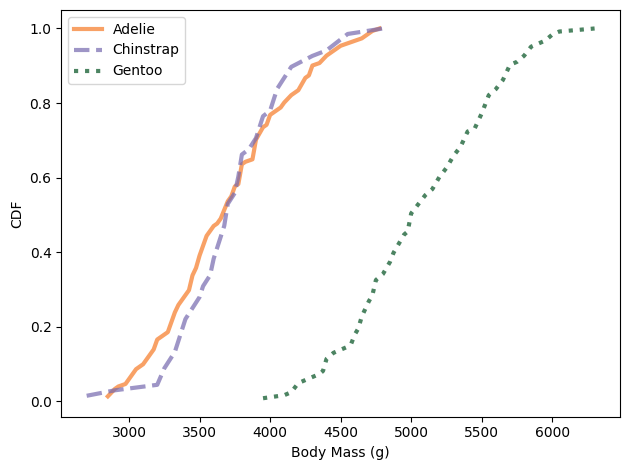

In [15]:
colname = 'Body Mass (g)'
plot_cdfs(df, colname)

Culmen depth and body mass distinguish Gentoo penguins from the other two species, but these features might not add a lot of additional information, beyond what we get from flipper length and culmen length.

## Normal Models

Let's use these features to classify penguins. We'll proceed in the usual Bayesian way:

1. Define a prior distribution with the three possible species and a prior probability for each,

2. Compute the likelihood of the data for each hypothetical species, and then

3. Compute the posterior probability of each hypothesis.

To compute the likelihood of the data under each hypothesis, I'll use the data to estimate the parameters of a normal distribution for each species.

The following function takes a `DataFrame` and a column name; it returns a dictionary that maps from each species name to a `norm` object.

`norm` is defined in SciPy; it represents a normal distribution with a given mean and standard deviation.

In [16]:
from scipy.stats import norm

def make_norm_map(df, colname, by='Species2'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

For example, here's the dictionary of `norm` objects for flipper length:

In [17]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map.keys()

dict_keys(['Adelie', 'Chinstrap', 'Gentoo'])

Now suppose we measure a penguin and find that its flipper is 193 cm.  What is the probability of that measurement under each hypothesis?

The `norm` object provides `pdf`, which computes the probability density function (PDF) of the normal distribution.  We can use it to compute the likelihood of the observed data in a given distribution.

In [18]:
data = 193
flipper_map['Adelie'].pdf(data)

np.float64(0.054732511875530694)

The result is a probability density, so we can't interpret it as a probability.  But it is proportional to the likelihood of the data, so we can use it to update the prior.

Here's how we compute the likelihood of the data in each distribution.

In [19]:
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[np.float64(0.054732511875530694),
 np.float64(0.051721356158881626),
 np.float64(5.866045366199098e-05)]

Now we're ready to do the update.

## The Update

As usual I'll use a `Pmf` to represent the prior distribution.  For simplicity, let's assume that the three species are equally likely.

In [20]:
from empiricaldist import Pmf

prior = Pmf(1/3, hypos)
prior

,0
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


Now we can do the update in the usual way.

In [21]:
posterior = prior * likelihood
posterior.normalize()
posterior

,0
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


A penguin with a 193 mm flipper is unlikely to be a Gentoo, but might be either an Adélie or Chinstrap (assuming that the three species were equally likely before the measurement).

The following function encapsulates the steps we just ran.
It takes a `Pmf` representing the prior distribution, the observed data, and a map from each hypothesis to the distribution of the feature.

In [22]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

The return value is the posterior distribution.

Here's the previous example again, using `update_penguin`:

In [23]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,0
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


As we saw in the CDFs, flipper length does not distinguish strongly between Adélie and Chinstrap penguins.

But culmen length *can* make this distinction, so let's use it to do a second round of classification.
First we estimate distributions of culmen length for each species like this:

In [24]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

Now suppose we see a penguin with culmen length 48 mm.
We can use this data to update the prior.

In [25]:
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,0
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


A penguin with culmen length 48 mm is about equally likely to be a Chinstrap or Gentoo.

Using one feature at a time, we can often rule out one species or another, but we generally can't identify species with confidence.
We can do better using multiple features.

## Naive Bayesian Classification

To make it easier to do multiple updates, I'll use the following function, which takes a prior `Pmf`, a sequence of measurements and a corresponding sequence of dictionaries containing estimated distributions.

In [26]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier

    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution

    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

It performs a series of updates, using one variable at a time, and returns the posterior `Pmf`.

To test it, I'll use the same features we looked at in the previous section: culmen length and flipper length.

In [27]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

Now suppose we find a penguin with flipper length 193 mm and culmen length 48.
Here's the update:

In [28]:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,0
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


It is almost certain to be a Chinstrap.

In [29]:
posterior.max_prob()

'Chinstrap'

We can loop through the dataset and classify each penguin with these two features.

In [30]:
import numpy as np

df['Classification'] = "None"

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

This loop adds a column called `Classification` to the `DataFrame`; it contains the species with the maximum posterior probability for each penguin.

So let's see how many we got right.

In [31]:
len(df)

342

In [32]:
valid = df['Classification'].notna()
valid.sum()

np.int64(342)

In [33]:
same = df['Species2'] == df['Classification']
same.sum()

np.int64(324)

There are 344 penguins in the dataset, but two of them are missing measurements, so we have 342 valid cases.
Of those, 324 are classified correctly, which is almost 95%.

In [34]:
same.sum() / valid.sum()

np.float64(0.9473684210526315)

The following function encapsulates these steps.

In [35]:
def accuracy(df):
    """Compute the accuracy of classification."""
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

The classifier we used in this section is called "naive" because it ignores correlations between the features.  To see why that matters, I'll make a less naive classifier: one that takes into account the joint distribution of the features.

## Joint Distributions

I'll start by making a scatter plot of the data.

In [36]:
import matplotlib.pyplot as plt

def scatterplot(df, var1, var2):
    """Make a scatter plot."""
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var1], group[var2],
                 label=species, ls="None", alpha=0.3)

    decorate(xlabel=var1, ylabel=var2)

Here's a scatter plot of culmen length and flipper length for the three species.

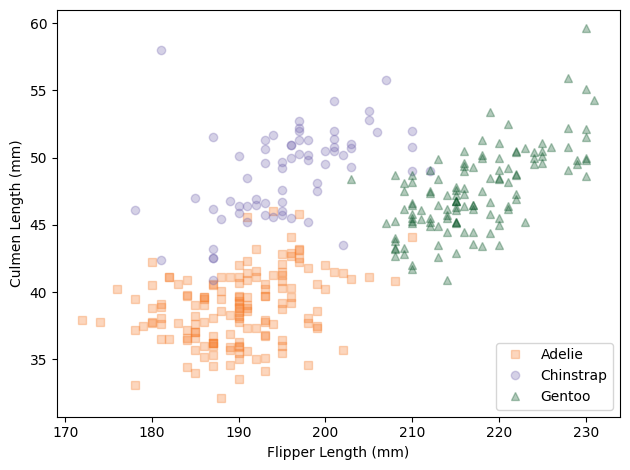

In [37]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

Within each species, the joint distribution of these measurements forms an oval shape, at least roughly.  The orientation of the ovals is along a diagonal, which indicates that there is a correlation between culmen length and flipper length.

If we ignore these correlations, we are assuming that the features are independent.  To see what that looks like, I'll make a joint distribution for each species assuming independence.

The following function makes a discrete `Pmf` that approximates a normal distribution.

In [38]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution."""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

We can use it, along with `make_joint`, to make a joint distribution of culmen length and flipper length for each species.

In [39]:
from utils import make_joint

joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

The following figure compares a scatter plot of the data to the contours of the joint distributions, assuming independence.

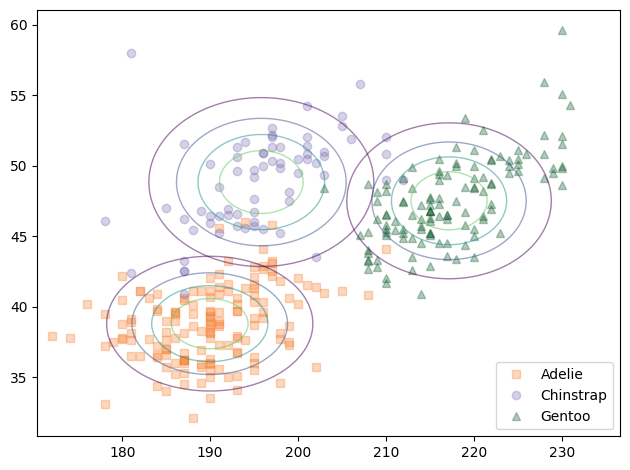

In [40]:
from utils import plot_contour

scatterplot(df, var1, var2)
for species in hypos:
    plot_contour(joint_map[species], alpha=0.5)

The contours of a joint normal distribution form ellipses.
In this example, because the features are uncorrelated, the ellipses are aligned with the axes.
But they are not well aligned with the data.

We can make a better model of the data, and use it to compute better likelihoods, with a multivariate normal distribution.

## Multivariate Normal Distribution

As we have seen, a univariate normal distribution is characterized by its mean and standard deviation.

A multivariate normal distribution is characterized by the means of the features and the **covariance matrix**, which contains **variances**, which quantify the spread of the features, and the **covariances**, which quantify the relationships among them.

We can use the data to estimate the means and covariance matrix for the population of penguins.
First I'll select the columns we want.

In [41]:
features = df[[var1, var2]]

And compute the means.

In [42]:
mean = features.mean()
mean

,0
Flipper Length (mm),200.915205
Culmen Length (mm),43.921930


We can also compute the covariance matrix:

In [43]:
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


The result is a `DataFrame` with one row and one column for each feature.  The elements on the diagonal are the variances; the elements off the diagonal are covariances.

By themselves, variances and covariances are hard to interpret.  We can use them to compute standard deviations and correlation coefficients, which are easier to interpret, but the details of that calculation are not important right now.

Instead, we'll pass the covariance matrix to `multivariate_normal`, which is a SciPy function that creates an object that represents a multivariate normal distribution.

As arguments it takes a sequence of means and a covariance matrix:

In [44]:
from scipy.stats import multivariate_normal

multinorm = multivariate_normal(mean, cov)

The following function makes a `multivariate_normal` object for each species.

In [45]:
def make_multinorm_map(df, colnames):
    """Make a map from each species to a multivariate normal."""
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

Here's how we make this map for the first two features, flipper length and culmen length.

In [46]:
multinorm_map = make_multinorm_map(df, [var1, var2])

## Visualizing a Multivariate Normal Distribution

This section uses some NumPy magic to generate contour plots for multivariate normal distributions.  If that's interesting for you, great!  Otherwise, feel free to skip to the results.  In the next section we'll do the actual classification, which turns out to be easier than the visualization.

I'll start by making a contour map for the distribution of features among Adélie penguins.  
Here are the univariate distributions for the two features we'll use and the multivariate distribution we just computed.

In [47]:
norm1 = flipper_map['Adelie']
norm2 = culmen_map['Adelie']
multinorm = multinorm_map['Adelie']

I'll make a discrete `Pmf` approximation for each of the univariate distributions.

In [48]:
pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2)

And use them to make a mesh grid that contains all pairs of values.

In [49]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

The mesh is represented by two arrays: the first contains the quantities from `pmf1` along the `x` axis; the second contains the quantities from `pmf2` along the `y` axis.

In order to evaluate the multivariate distribution for each pair of values, we have to "stack" the arrays.

In [50]:
pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

The result is a 3-D array that you can think of as a 2-D array of pairs.  When we pass this array to `multinorm.pdf`, it evaluates the probability density function of the distribution for each pair of values.

In [51]:
densities = multinorm.pdf(pos)
densities.shape

(101, 101)

The result is an array of probability densities.  If we put them in a `DataFrame` and normalize them, the result is a discrete approximation of the joint distribution of the two features.

In [52]:
from utils import normalize

joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
normalize(joint)

np.float64(15.87134363991382)

Here's what the result looks like.

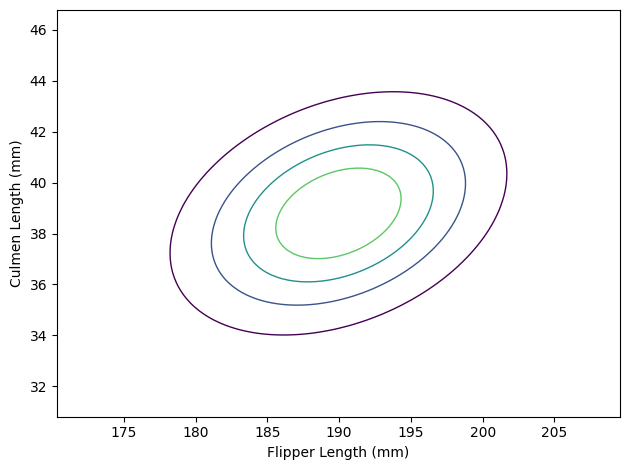

In [53]:
plot_contour(joint)
decorate(xlabel=var1,
         ylabel=var2)

The contours of a multivariate normal distribution are still ellipses, but now that we have taken into account the correlation between the features, the ellipses are no longer aligned with the axes.

The following function encapsulate the steps we just did.

In [54]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.

    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

The following figure shows a scatter plot of the data along with the contours of the multivariate normal distribution for each species.

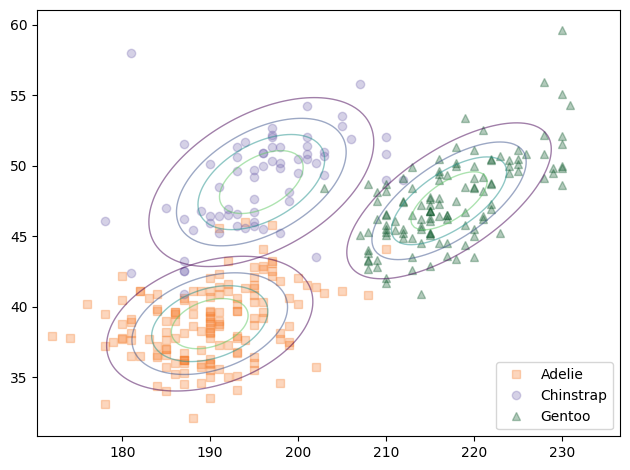

In [55]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.5)

Because the multivariate normal distribution takes into account the correlations between features, it is a better model for the data.  And there is less overlap in the contours of the three distributions, which suggests that they should yield better classifications.

## A Less Naive Classifier

In a previous section we used `update_penguin` to update a prior `Pmf` based on observed data and a collection of `norm` objects that model the distribution of observations under each hypothesis.  Here it is again:

In [56]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

Last time we used this function, the values in `norm_map` were `norm` objects, but it also works if they are `multivariate_normal` objects.

We can use it to classify a penguin with flipper length 193 and culmen length 48:

In [57]:
data = 193, 48
update_penguin(prior, data, multinorm_map)

,0
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


A penguin with those measurements is almost certainly a Chinstrap.

Now let's see if this classifier does any better than the naive Bayesian classifier.
I'll apply it to each penguin in the dataset:

In [58]:
df['Classification'] = "None"

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

And compute the accuracy:

In [59]:
accuracy(df)

np.float64(0.9532163742690059)

It turns out to be only a little better: the accuracy is 95.3%, compared to 94.7% for the naive Bayesian classifier.

## Summary

In this chapter, we implemented a naive Bayesian classifier, which is "naive" in the sense that it assumes that the features it uses for classification are independent.

To see how bad that assumption is, we also implemented a classifier that uses a multivariate normal distribution to model the joint distribution of the features, which includes their dependencies.

In this example, the non-naive classifier is only marginally better.
In one way, that's disappointing.  After all that work, it would have been nice to see a bigger improvement.
But in another way, it's good news.  In general, a naive Bayesian classifier is easier to implement and requires less computation.  If it works nearly as well as a more complex algorithm, it might be a good choice for practical purposes.

Speaking of practical purposes, you might have noticed that this example isn't very useful.  If we want to identify the species of a penguin, there are easier ways than measuring its flippers and beak.

But there *are* scientific uses for this type of classification.  One of them is the subject of the research paper we started with: [sexual dimorphism](https://en.wikipedia.org/wiki/Sexual_dimorphism), that is, differences in shape between male and female animals.

In some species, like angler fish, males and females look very different.  In other species, like mockingbirds, they are difficult to tell apart.
And dimorphism is worth studying because it provides insight into social behavior, sexual selection, and evolution.

One way to quantify the degree of sexual dimorphism in a species is to use a classification algorithm like the one in this chapter.  If you can find a set of features that makes it possible to classify individuals by sex with high accuracy, that's evidence of high dimorphism.

As an exercise, you can use the dataset from this chapter to classify penguins by sex and see which of the three species is the most dimorphic.

## Exercises

**Exercise:**  In my example I used culmen length and flipper length because they seemed to provide the most power to distinguish the three species.  But maybe we can do better by using more features.

Make a naive Bayesian classifier that uses all four measurements in the dataset: culmen length and depth, flipper length, and body mass.
Is it more accurate than the model with two features?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:**  One of the reasons the penguin dataset was collected was to quantify sexual dimorphism in different penguin species, that is, physical differences between male and female penguins.  One way to quantify dimorphism is to use measurements to classify penguins by sex.  If a species is more dimorphic, we expect to be able to classify them more accurately.

As an exercise, pick a species and use a Bayesian classifier (naive or not) to classify the penguins by sex.  Which features are most useful?  What accuracy can you achieve?

Note: One Gentoo penguin has an invalid value for `Sex`.  I used the following code to select one species and filter out invalid data.

In [ ]:
gentoo = (df['Species2'] == 'Gentoo')
subset = df[gentoo].copy()

In [ ]:
subset['Sex'].value_counts()

In [ ]:
valid = df['Sex'] != '.'
valid.sum()

In [ ]:
subset = df[valid & gentoo].copy()

OK, you can finish it off from here.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here